# Workshop 10 - Training Neural Networks (Learning rate scheduling and optimisers)

Code for workshop 10.  This will use Keras (within tensorflow v2)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


## Load data
We will use MNIST, which is a set of small images (28x28) that contain 10 digits - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


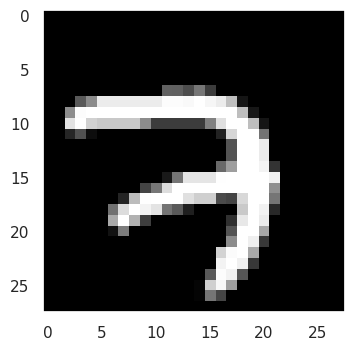

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

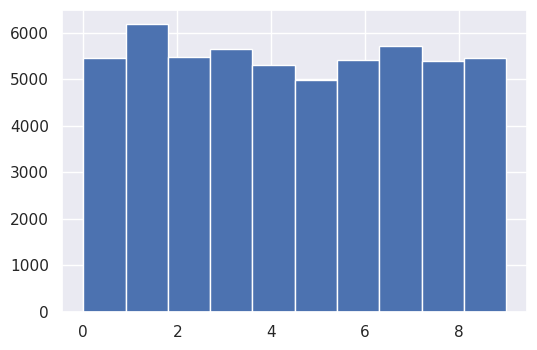

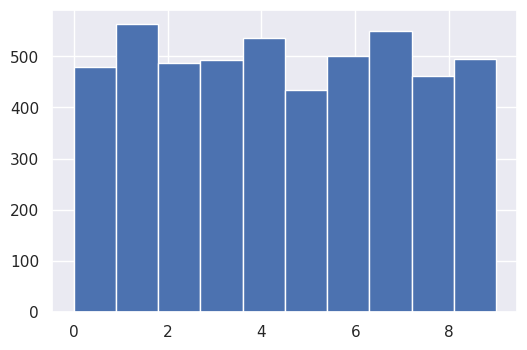

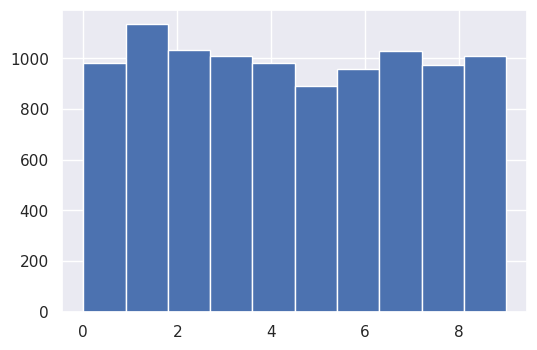

In [6]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [7]:
# Some key parameters
n_train = 3000
n_valid = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [8]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

In [9]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [10]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [11]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [40]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) 

In [13]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb] + further_callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [14]:
valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 231us/sample - loss: 2.2120 - accuracy: 0.2830 - val_loss: 2.0606 - val_accuracy: 0.4500
Epoch 2/20
3000/3000 [==============================] - 0s 155us/sample - loss: 1.6726 - accuracy: 0.5580 - val_loss: 1.2106 - val_accuracy: 0.6410
Epoch 3/20
3000/3000 [==============================] - 0s 155us/sample - loss: 0.8457 - accuracy: 0.7510 - val_loss: 0.6761 - val_accuracy: 0.7920
Epoch 4/20
3000/3000 [==============================] - 0s 157us/sample - loss: 0.5472 - accuracy: 0.8290 - val_loss: 0.5089 - val_accuracy: 0.8590
Epoch 5/20
3000/3000 [==============================] - 0s 160us/sample - loss: 0.4366 - accuracy: 0.8590 - val_loss: 0.4785 - val_accuracy: 0.8600
Epoch 6/20
3000/3000 [==============================] - 0s 157us/sample - loss: 0.3818 - accuracy: 0.8867 - val_loss: 0.4346 - val_accuracy: 0.8800
Epoch 7/20
3000/3000 [==============================] - 0s 156us

In [15]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

[7 2 1]
['7' '2' '1']
['7' '2' '1']


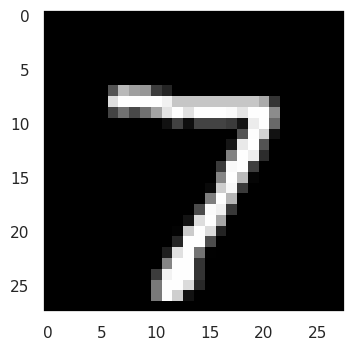

In [16]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [17]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.3051235193103552, 0.9098]


In [18]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.01 0.   0.01 0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]]


# Manually exploring the learning rate



Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 228us/sample - loss: 1.2537 - accuracy: 0.6187 - val_loss: 0.5174 - val_accuracy: 0.8410
Epoch 2/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.3784 - accuracy: 0.8810 - val_loss: 0.3913 - val_accuracy: 0.8840
Epoch 3/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.2737 - accuracy: 0.9197 - val_loss: 0.3078 - val_accuracy: 0.9040
Epoch 4/20
3000/3000 [==============================] - 0s 152us/sample - loss: 0.2181 - accuracy: 0.9357 - val_loss: 0.3135 - val_accuracy: 0.9070
Epoch 5/20
3000/3000 [==============================] - 0s 152us/sample - loss: 0.1713 - accuracy: 0.9500 - val_loss: 0.2535 - val_accuracy: 0.9340
Epoch 6/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.1502 - accuracy: 0.9530 - val_loss: 0.2218 - val_accuracy: 0.9380
Epoch 7/20
3000/3000 [==============================] - 0s 155us

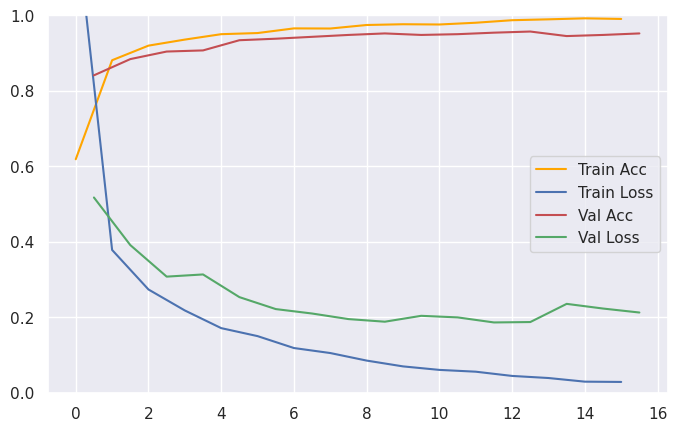

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 224us/sample - loss: 1.5194 - accuracy: 0.5133 - val_loss: 0.6192 - val_accuracy: 0.7890
Epoch 2/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.4607 - accuracy: 0.8530 - val_loss: 0.4137 - val_accuracy: 0.8810
Epoch 3/20
3000/3000 [==============================] - 0s 152us/sample - loss: 0.3339 - accuracy: 0.8983 - val_loss: 0.3946 - val_accuracy: 0.8920
Epoch 4/20
3000/3000 [==============================] - 0s 152us/sample - loss: 0.2782 - accuracy: 0.9117 - val_loss: 0.3441 - val_accuracy: 0.9000
Epoch 5/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.2321 - accuracy: 0.9307 - val_loss: 0.3167 - val_accuracy: 0.9110
Epoch 6/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.2024 - accuracy: 0.9420 - val_loss: 0.3301 - val_accuracy: 0.8980
Epoch 7/20
3000/3000 [==============================] - 0s 153us

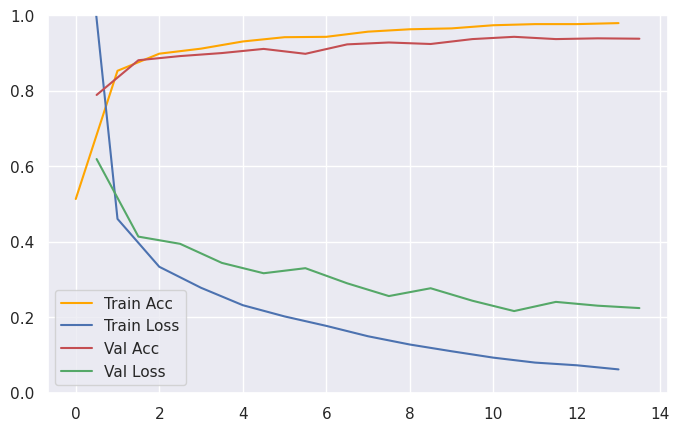

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 224us/sample - loss: 1.3851 - accuracy: 0.5813 - val_loss: 0.6628 - val_accuracy: 0.7810
Epoch 2/20
3000/3000 [==============================] - 0s 156us/sample - loss: 0.4459 - accuracy: 0.8650 - val_loss: 0.4128 - val_accuracy: 0.8900
Epoch 3/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.3315 - accuracy: 0.8990 - val_loss: 0.3717 - val_accuracy: 0.9020
Epoch 4/20
3000/3000 [==============================] - 0s 157us/sample - loss: 0.2711 - accuracy: 0.9173 - val_loss: 0.4089 - val_accuracy: 0.8840
Epoch 5/20
3000/3000 [==============================] - 0s 151us/sample - loss: 0.2341 - accuracy: 0.9280 - val_loss: 0.3095 - val_accuracy: 0.9140
Epoch 6/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.2002 - accuracy: 0.9393 - val_loss: 0.3136 - val_accuracy: 0.9150
Epoch 7/20
3000/3000 [==============================] - 0s 155us

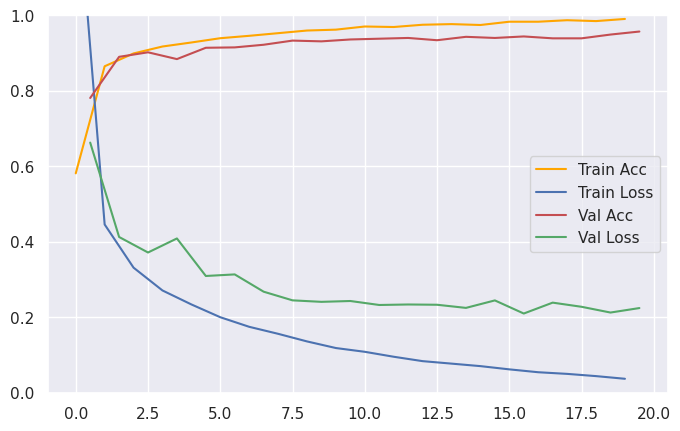

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 223us/sample - loss: 1.9187 - accuracy: 0.4723 - val_loss: 1.0632 - val_accuracy: 0.7350
Epoch 2/20
3000/3000 [==============================] - 0s 152us/sample - loss: 0.6692 - accuracy: 0.7937 - val_loss: 0.5188 - val_accuracy: 0.8530
Epoch 3/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.4230 - accuracy: 0.8713 - val_loss: 0.4276 - val_accuracy: 0.8760
Epoch 4/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.3375 - accuracy: 0.8940 - val_loss: 0.3842 - val_accuracy: 0.8870
Epoch 5/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.2941 - accuracy: 0.9140 - val_loss: 0.3613 - val_accuracy: 0.9040
Epoch 6/20
3000/3000 [==============================] - 0s 151us/sample - loss: 0.2616 - accuracy: 0.9220 - val_loss: 0.3262 - val_accuracy: 0.9100
Epoch 7/20
3000/3000 [==============================] - 0s 154us

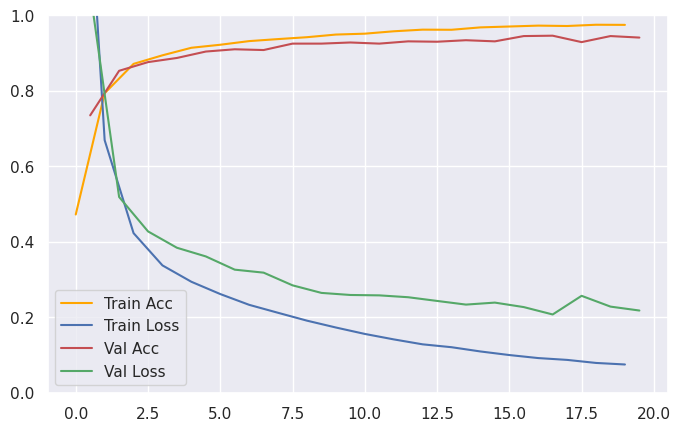

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 229us/sample - loss: 2.2414 - accuracy: 0.2177 - val_loss: 2.1539 - val_accuracy: 0.3290
Epoch 2/20
3000/3000 [==============================] - 0s 152us/sample - loss: 1.8805 - accuracy: 0.5153 - val_loss: 1.4551 - val_accuracy: 0.6760
Epoch 3/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.9635 - accuracy: 0.7517 - val_loss: 0.7265 - val_accuracy: 0.7800
Epoch 4/20
3000/3000 [==============================] - 0s 155us/sample - loss: 0.5561 - accuracy: 0.8287 - val_loss: 0.5835 - val_accuracy: 0.8250
Epoch 5/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.4411 - accuracy: 0.8623 - val_loss: 0.4935 - val_accuracy: 0.8620
Epoch 6/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.3761 - accuracy: 0.8883 - val_loss: 0.4059 - val_accuracy: 0.8890
Epoch 7/20
3000/3000 [==============================] - 0s 153us

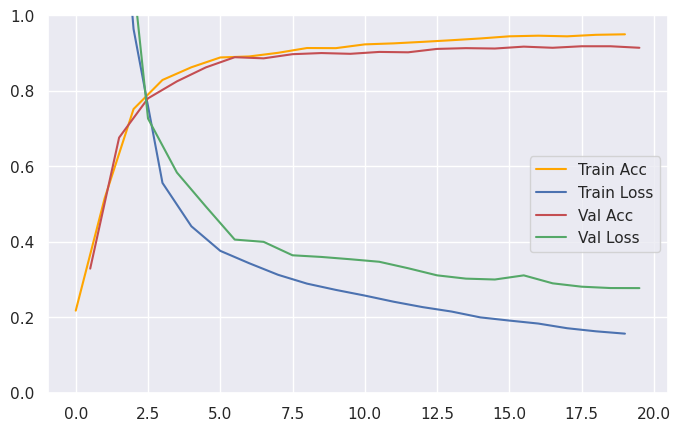

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 225us/sample - loss: 2.2872 - accuracy: 0.1180 - val_loss: 2.2306 - val_accuracy: 0.2070
Epoch 2/20
3000/3000 [==============================] - 0s 152us/sample - loss: 2.1560 - accuracy: 0.3523 - val_loss: 2.0679 - val_accuracy: 0.4810
Epoch 3/20
3000/3000 [==============================] - 0s 153us/sample - loss: 1.8980 - accuracy: 0.5730 - val_loss: 1.6749 - val_accuracy: 0.6440
Epoch 4/20
3000/3000 [==============================] - 0s 152us/sample - loss: 1.3618 - accuracy: 0.6883 - val_loss: 1.0591 - val_accuracy: 0.7530
Epoch 5/20
3000/3000 [==============================] - 0s 151us/sample - loss: 0.8536 - accuracy: 0.7700 - val_loss: 0.7106 - val_accuracy: 0.8130
Epoch 6/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.6172 - accuracy: 0.8217 - val_loss: 0.5761 - val_accuracy: 0.8360
Epoch 7/20
3000/3000 [==============================] - 0s 154us

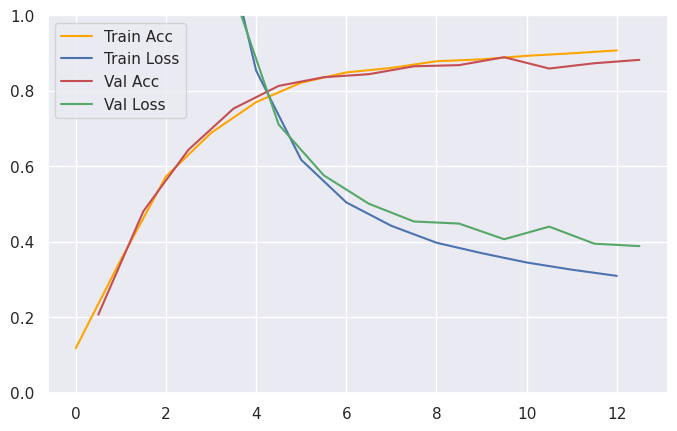

[[0.05, 0.957, 0.9614], [0.04, 0.943, 0.9506], [0.03, 0.957, 0.9504], [0.02, 0.946, 0.9491], [0.01, 0.918, 0.9313], [0.005, 0.889, 0.8866]]


In [19]:
# Learning rate
res=[]
for lr in [5, 4, 3, 2, 1, 0.5]:
    valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[lr*learningrate,valacc,testacc]]
print(res)

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 186us/sample - loss: 2.1357 - accuracy: 0.4150 - val_loss: 1.8777 - val_accuracy: 0.6170
Epoch 2/20
3000/3000 [==============================] - 0s 122us/sample - loss: 1.3017 - accuracy: 0.7220 - val_loss: 0.8139 - val_accuracy: 0.8040
Epoch 3/20
3000/3000 [==============================] - 0s 123us/sample - loss: 0.6016 - accuracy: 0.8357 - val_loss: 0.5421 - val_accuracy: 0.8460
Epoch 4/20
3000/3000 [==============================] - 0s 122us/sample - loss: 0.4373 - accuracy: 0.8757 - val_loss: 0.4797 - val_accuracy: 0.8720
Epoch 5/20
3000/3000 [==============================] - 0s 121us/sample - loss: 0.3786 - accuracy: 0.8903 - val_loss: 0.4486 - val_accuracy: 0.8760
Epoch 6/20
3000/3000 [==============================] - 0s 123us/sample - loss: 0.3507 - accuracy: 0.8933 - val_loss: 0.4335 - val_accuracy: 0.8800
Epoch 7/20
3000/3000 [==============================] - 0s 123us

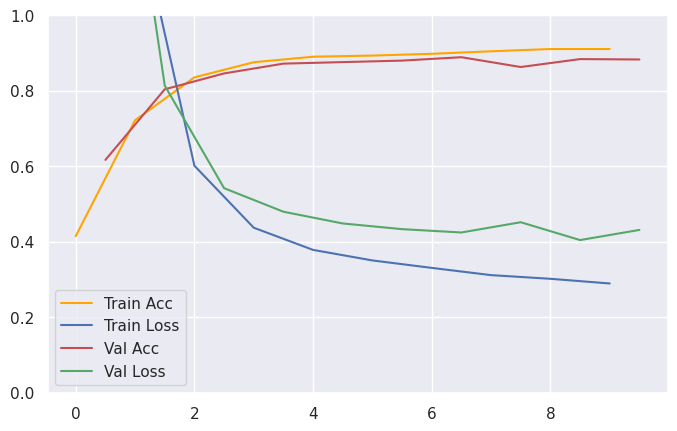

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 193us/sample - loss: 1.8259 - accuracy: 0.5697 - val_loss: 1.1153 - val_accuracy: 0.7780
Epoch 2/20
3000/3000 [==============================] - 0s 130us/sample - loss: 0.7016 - accuracy: 0.8187 - val_loss: 0.5272 - val_accuracy: 0.8610
Epoch 3/20
3000/3000 [==============================] - 0s 129us/sample - loss: 0.4463 - accuracy: 0.8667 - val_loss: 0.5067 - val_accuracy: 0.8400
Epoch 4/20
3000/3000 [==============================] - 0s 130us/sample - loss: 0.3803 - accuracy: 0.8873 - val_loss: 0.4551 - val_accuracy: 0.8570
Epoch 5/20
3000/3000 [==============================] - 0s 131us/sample - loss: 0.3460 - accuracy: 0.8967 - val_loss: 0.4267 - val_accuracy: 0.8770
Epoch 6/20
3000/3000 [==============================] - 0s 130us/sample - loss: 0.3208 - accuracy: 0.9073 - val_loss: 0.4058 - val_accuracy: 0.8870
Epoch 7/20
3000/3000 [==============================] - 0s 130us

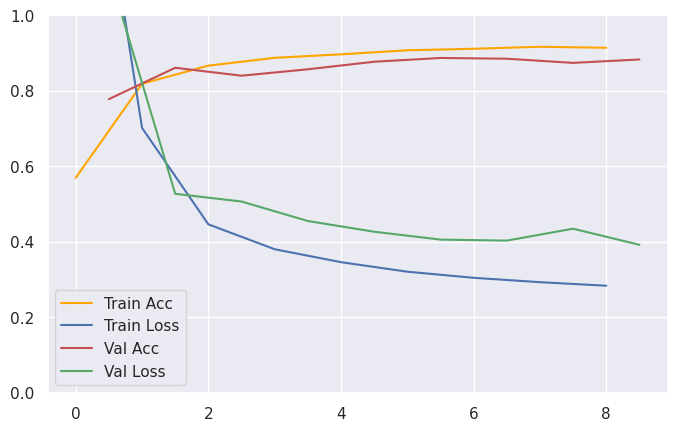

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 225us/sample - loss: 2.2300 - accuracy: 0.3047 - val_loss: 2.1510 - val_accuracy: 0.4210
Epoch 2/20
3000/3000 [==============================] - 0s 154us/sample - loss: 1.9392 - accuracy: 0.5143 - val_loss: 1.6273 - val_accuracy: 0.6130
Epoch 3/20
3000/3000 [==============================] - 0s 154us/sample - loss: 1.1215 - accuracy: 0.7307 - val_loss: 0.7633 - val_accuracy: 0.7940
Epoch 4/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.5991 - accuracy: 0.8273 - val_loss: 0.5503 - val_accuracy: 0.8340
Epoch 5/20
3000/3000 [==============================] - 0s 155us/sample - loss: 0.4537 - accuracy: 0.8677 - val_loss: 0.4975 - val_accuracy: 0.8530
Epoch 6/20
3000/3000 [==============================] - 0s 153us/sample - loss: 0.3905 - accuracy: 0.8813 - val_loss: 0.4129 - val_accuracy: 0.8860
Epoch 7/20
3000/3000 [==============================] - 0s 155us

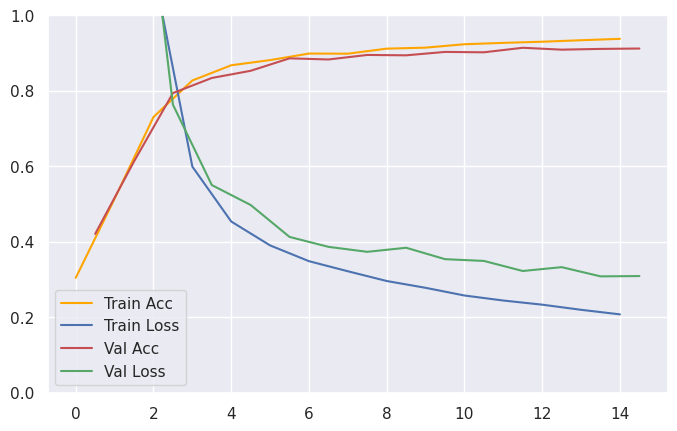

[[1, 0.889, 0.883], [2, 0.887, 0.9002], [3, 0.914, 0.9147]]


In [20]:
# Number of layers
res=[]
for n in [1, 2, 3]:
    valacc, testacc, history, discard = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc,testacc]]
print(res)

# Exploring optimizers

Let us compare different optimizers on the same task.

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 259us/sample - loss: 2.3105 - accuracy: 0.1393 - val_loss: 2.2982 - val_accuracy: 0.1330
Epoch 2/20
3000/3000 [==============================] - 0s 154us/sample - loss: 2.2941 - accuracy: 0.1657 - val_loss: 2.2838 - val_accuracy: 0.1540
Epoch 3/20
3000/3000 [==============================] - 0s 153us/sample - loss: 2.2787 - accuracy: 0.1897 - val_loss: 2.2697 - val_accuracy: 0.1900
Epoch 4/20
3000/3000 [==============================] - 0s 155us/sample - loss: 2.2635 - accuracy: 0.2147 - val_loss: 2.2554 - val_accuracy: 0.2240
Epoch 5/20
3000/3000 [==============================] - 0s 153us/sample - loss: 2.2479 - accuracy: 0.2493 - val_loss: 2.2402 - val_accuracy: 0.2660
Epoch 6/20
3000/3000 [==============================] - 0s 153us/sample - loss: 2.2313 - accuracy: 0.2847 - val_loss: 2.2237 - val_accuracy: 0.3220
Epoch 7/20
3000/3000 [==============================] - 0s 154us

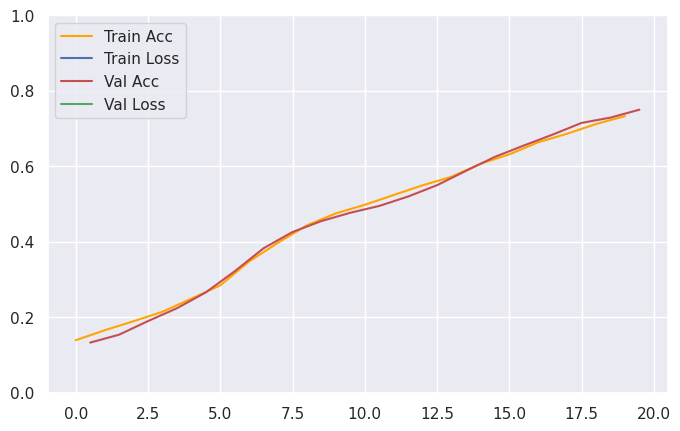

In [21]:
learning_rate=0.001
optimizer=keras.optimizers.SGD
valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, learning_rate, n_train, n_valid, n_epochs, batch_size)
plot_history(history)

# Your Tasks

Try out the optimizers RMSprop, Adam, Nadam, AdaMax with default settings by copying the above code and swapping out the optimizer. 

Which one has the best final classifier? 

Which one converges fastest? 

Which learning curve is the smoothest?

Which one would you choose?

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 237us/sample - loss: 1.0570 - accuracy: 0.6630 - val_loss: 0.4101 - val_accuracy: 0.8760
Epoch 2/20
3000/3000 [==============================] - 0s 155us/sample - loss: 0.3124 - accuracy: 0.9133 - val_loss: 0.3568 - val_accuracy: 0.8960
Epoch 3/20
3000/3000 [==============================] - 0s 154us/sample - loss: 0.2313 - accuracy: 0.9313 - val_loss: 0.2948 - val_accuracy: 0.9190
Epoch 4/20
3000/3000 [==============================] - 0s 166us/sample - loss: 0.1768 - accuracy: 0.9487 - val_loss: 0.2583 - val_accuracy: 0.9240
Epoch 5/20
3000/3000 [==============================] - 0s 156us/sample - loss: 0.1337 - accuracy: 0.9593 - val_loss: 0.2192 - val_accuracy: 0.9340
Epoch 6/20
3000/3000 [==============================] - 0s 161us/sample - loss: 0.1051 - accuracy: 0.9680 - val_loss: 0.2051 - val_accuracy: 0.9440
Epoch 7/20
3000/3000 [==============================] - 0s 157us

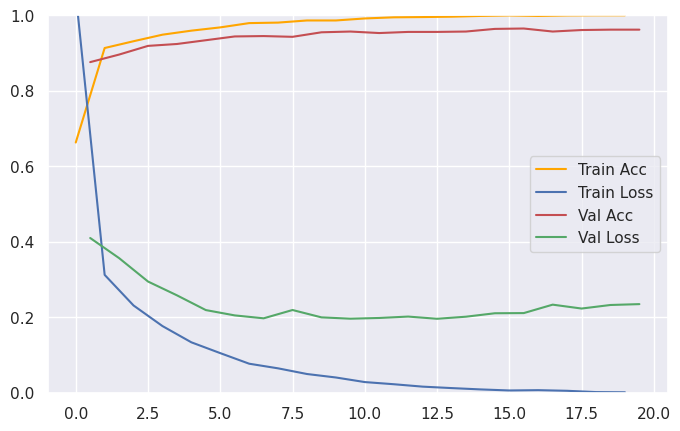

In [37]:
learning_rate=0.001
optimizer=keras.optimizers.Adam
valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, learning_rate, n_train, n_valid, n_epochs, batch_size)
plot_history(history)

# Exploring learning rate schedules

Let us compare different learning rate schedules on the same task.

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 307us/sample - loss: 0.5132 - accuracy: 0.8267 - val_loss: 0.2518 - val_accuracy: 0.9250
Epoch 2/20
3000/3000 [==============================] - 0s 158us/sample - loss: 0.1925 - accuracy: 0.9457 - val_loss: 0.3721 - val_accuracy: 0.8980
Epoch 3/20
3000/3000 [==============================] - 0s 155us/sample - loss: 0.1764 - accuracy: 0.9463 - val_loss: 0.6152 - val_accuracy: 0.8770
Epoch 4/20
3000/3000 [==============================] - 0s 156us/sample - loss: 0.1847 - accuracy: 0.9557 - val_loss: 0.5258 - val_accuracy: 0.9050


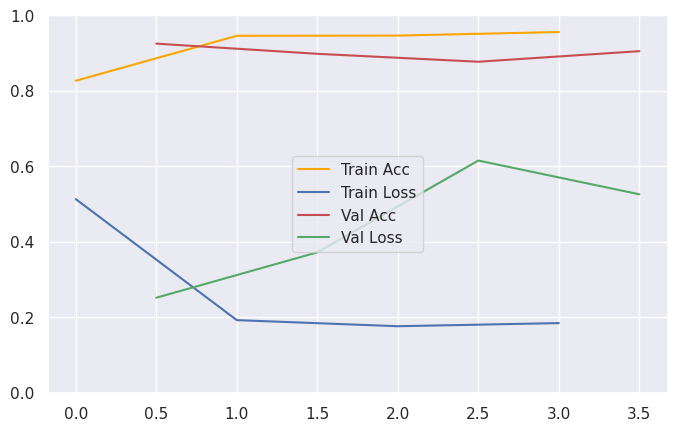

In [23]:
# Define scheduler functions
def piecewise_const(epoch):
  if epoch < 10:
    return 0.01
  else:
    return 0.001

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_const)
valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, learning_rate, n_train, n_valid, n_epochs, batch_size,[lr_scheduler])
plot_history(history)

# Your Tasks: 

Write a new learning rate scheduler (copy from above and edit) that does a simple '1cycle' scheduling. Use the manual learning rate tests above BUT WITH THE NADAM OPTIMIZER! to choose a maximum learning rate. 

Manually experiment with the number of iterations for the upslope/down slope. 

Is the convergence faster than with a fixed learning rate?

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 1s 355us/sample - loss: 2.3028 - accuracy: 0.1680 - val_loss: 2.3093 - val_accuracy: 0.1610
Epoch 2/50
3000/3000 [==============================] - 0s 158us/sample - loss: 0.6664 - accuracy: 0.7863 - val_loss: 0.4332 - val_accuracy: 0.8650
Epoch 3/50
3000/3000 [==============================] - 0s 158us/sample - loss: 0.2394 - accuracy: 0.9303 - val_loss: 0.2441 - val_accuracy: 0.9310
Epoch 4/50
3000/3000 [==============================] - 0s 158us/sample - loss: 0.1704 - accuracy: 0.9487 - val_loss: 0.1961 - val_accuracy: 0.9500
Epoch 5/50
3000/3000 [==============================] - 0s 159us/sample - loss: 0.1660 - accuracy: 0.9503 - val_loss: 0.2837 - val_accuracy: 0.9410
Epoch 6/50
3000/3000 [==============================] - 0s 158us/sample - loss: 28.3641 - accuracy: 0.7377 - val_loss: 1.4894 - val_accuracy: 0.8610
Epoch 7/50
3000/3000 [==============================] - 0s 160u

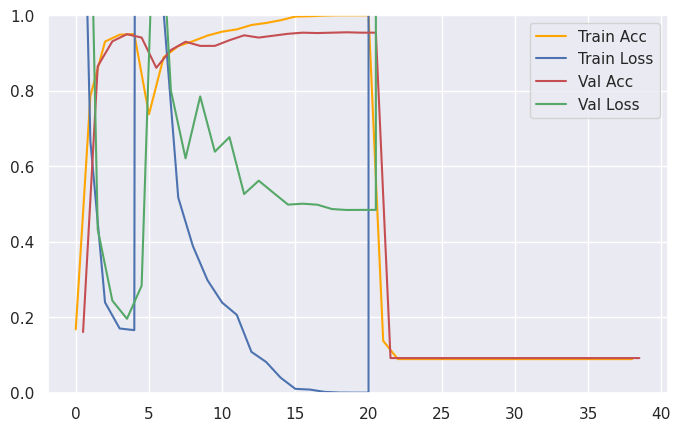

In [44]:
# Define scheduler functions
def cycle_schedule(epoch):
    max_lr = 0.001*20
    min_lr = max_lr/10
    init_lr = min_lr
    
    
    
    if epoch <= 10:
        return init_lr*epoch
    elif epoch <=20:
        return max_lr - init_lr*(epoch-10)
    else:
        return min_lr-(epoch/20)

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cycle_schedule)
valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, learning_rate, n_train, n_valid, 50, batch_size,[lr_scheduler])
plot_history(history)

Train on 3000 samples, validate on 1000 samples
Epoch 1/20
3000/3000 [==============================] - 1s 311us/sample - loss: 0.9281 - accuracy: 0.7560 - val_loss: 0.4010 - val_accuracy: 0.8830
Epoch 2/20
3000/3000 [==============================] - 0s 166us/sample - loss: 0.2734 - accuracy: 0.9173 - val_loss: 0.2958 - val_accuracy: 0.9190
Epoch 3/20
3000/3000 [==============================] - 0s 164us/sample - loss: 0.2142 - accuracy: 0.9413 - val_loss: 0.4324 - val_accuracy: 0.9140
Epoch 4/20
3000/3000 [==============================] - 0s 164us/sample - loss: 144.5947 - accuracy: 0.5390 - val_loss: 3.7756 - val_accuracy: 0.7460
Epoch 5/20
3000/3000 [==============================] - 0s 158us/sample - loss: 3.2678 - accuracy: 0.7320 - val_loss: 1.9732 - val_accuracy: 0.8120


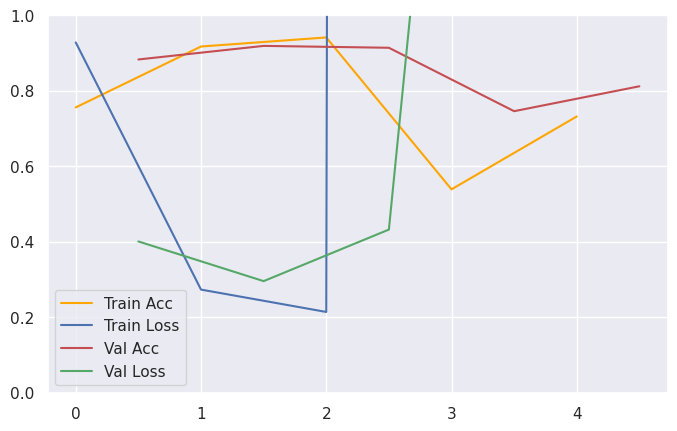

In [32]:
learningrate = 0.001

for lr in [20]:
    valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)